In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of optical absorption in GaAs 

We try to reproduce the results of the optical absorption of GaAs obtained with Yambo using the physics of the TLS

## TLS analysis of a single transition at 1.5 eV with a single gaussian pulse

The parameters common in the yambo and in the TLS analysis are

In [57]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
de_cv = 1.5 # the band gap in eV
intensity = 23758 # 23758 # # 95032 kW/cm2
energy = 1.52 # 1.52 # 1.5 # eV 
NETime = 500 # fs
ntimes = 10001 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

In [4]:
ref_run_dir = 'PHOTON_ECO/RT_singlek1.5_nosym'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi'
ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune'

In [5]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.external_field
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.carriers
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.polarization
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.current
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.RT_G_PAR


In [6]:
# ref_results.get_info()

In [7]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']

green = ref_results.RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
Bloch = P.buildBlochVectors(dm)

In [8]:
dft = ref_results.dft
dft.get_evals(set_scissor=scissor)

Apply a scissor of 0.9548 eV


array([[-1.29828944e+01, -8.31392810e-02, -2.68312675e-03,
         0.00000000e+00,  1.50000196e+00,  4.72523418e+00,
         4.73080659e+00,  4.73342509e+00]])

The cv transition is at 1.5 eV and the associated r dipole (x component) is

In [9]:
dipoles = ref_results.dipoles
x_dip = dipoles.get_r_dipole(0,0,1,0)
x_dip

(6.160434618186675+18.397226229218063j)

We compute the field amplitude and the Rabi coupling associated to a given theta

In [58]:
pars = G.pulseParametersFromIntensity(x_dip,intensity,fwhm=fwhm)
pars

time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.004685618562658017+0.013992906355431267j)
Rabi coupling (module) (fs^-1): 0.014756573097660382
field amplitude (V/m): 9460633.581454257
pulse area : 1.5707885382285562


{'Omega0': (0.004685618562658017+0.013992906355431267j),
 'Omega0_abs': 0.014756573097660382,
 'field_amplitude': 9460633.581454257,
 'theta': 1.5707885382285562}

In [49]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check thati its amplitude matches the
one of the yambo Ex field

In [50]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=pars['field_amplitude'],fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.7208340113370535 fs
width of the pulse 42.466090014400955 fs
fwhm of the pulse 100 fs


(0.0, 200.0)

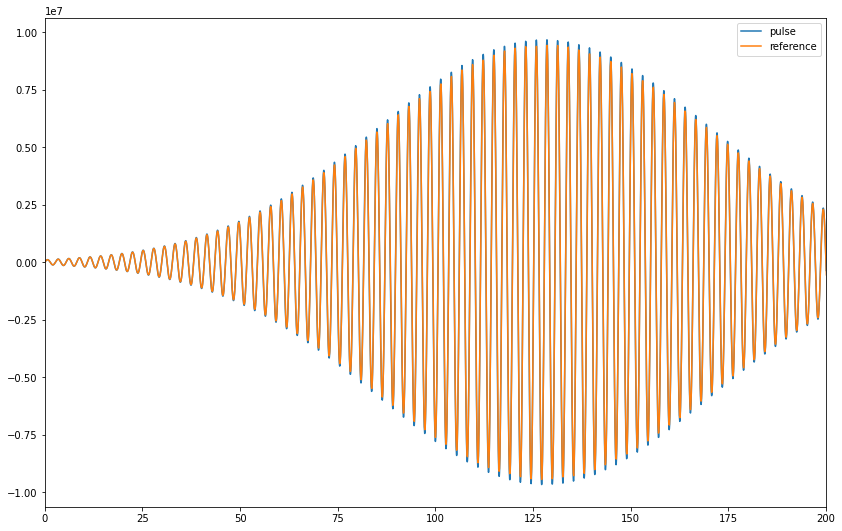

In [51]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,200)

In [59]:
Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm,envelope_only=True,verbose=False)

In [60]:
uprime0 = np.array([0.,0.,-1.])

In [61]:
delta = energy - de_cv # in eV
delta_fsm1 = delta/h_red # in fs^-1
delta_fsm1

0.030385348955306226

In [62]:
uprime = TLS.solveBlochEq(uprime0,time,Omega,mu=x_dip,delta=delta_fsm1)

We plot the carriers (rescaled by a factor 2 to be compared with the results of the yambo 
computation that has a spin degeneracy)

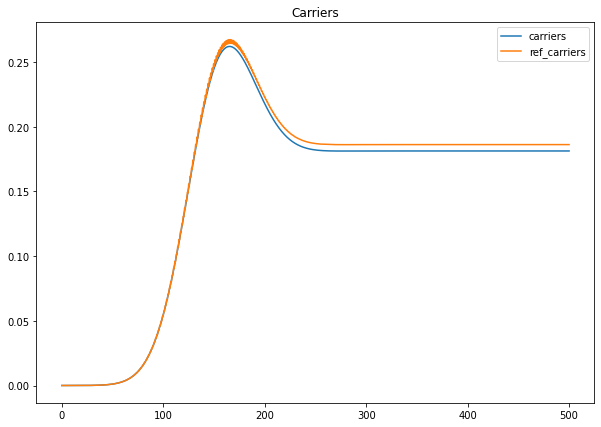

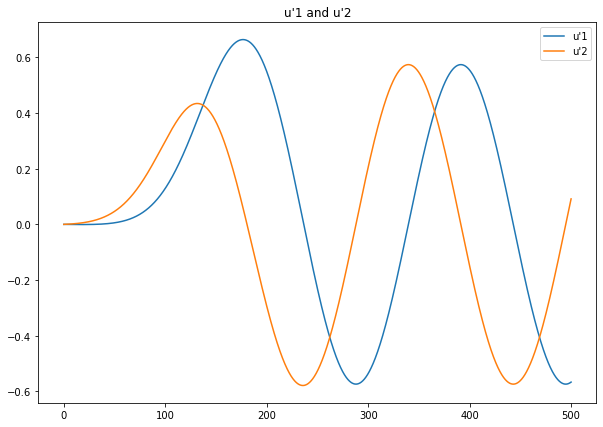

In [63]:
plt.figure(figsize=(10,7))
plt.title('Carriers')
plt.plot(time,(1+uprime[2]),label='carriers')
plt.plot(ref_time,ref_carriers,label='ref_carriers')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(time,uprime[0],label="u'1")
plt.plot(time,uprime[1],label="u'2")
plt.title("u'1 and u'2")
plt.legend()

We compare the other components of the Bloch vector in the original frame

In [64]:
u = TLS.convertToRotatingFrame(omega,time,uprime,invert=True)

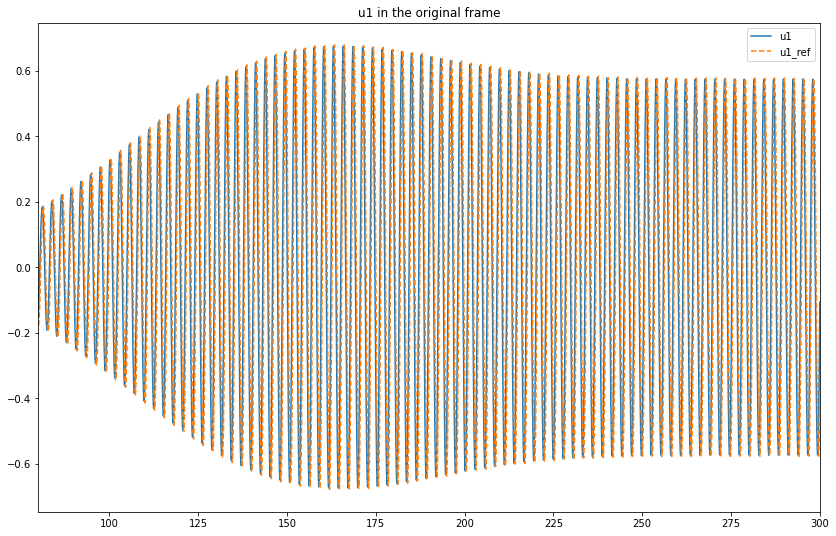

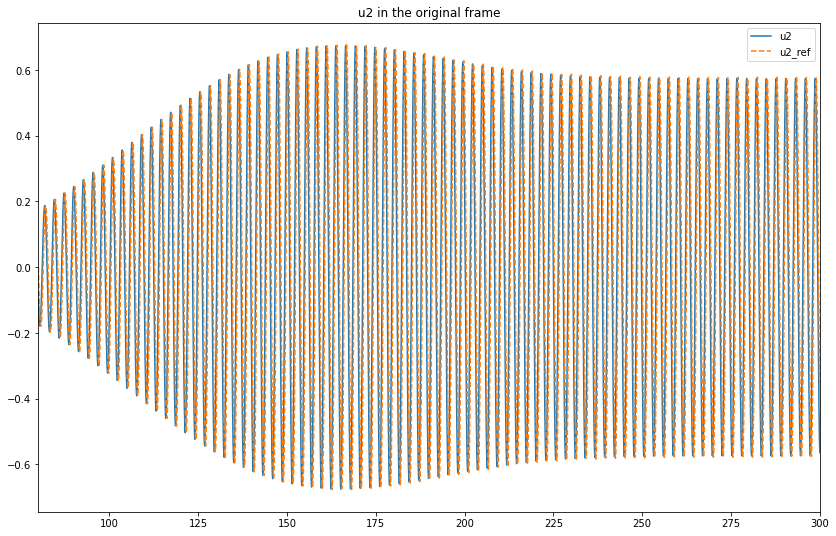

In [67]:
plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1')
plt.plot(time,Bloch[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1 in the original frame')
plt.xlim(80,300)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2')
plt.plot(time,Bloch[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2 in the original frame')
plt.xlim(80,300)
plt.legend()

The bloch vector built with the TLS is identical to the one extracted from the yambo computation for a single transition.

## TLS analysis of a single transition at 1.5 eV with a double gaussian pulse

The parameters common in the yambo and in the TLS analysis are

In [82]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
de_cv = 1.5 # the band gap in eV
int1 = 23758 # 23758 # # 95032 kW/cm2
int2 = 95032 # 23758 # # 95032 kW/cm2
energy = 1.5 # 1.52 # 1.5 # eV 
NETime = 2000 # fs
ntimes = 40001 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

# set the tstart of the second pulse as in the RT simulation
h = C.Planck_ev_ps*1e3
period = h/energy # in fs
tstart = period*218 #363

In [70]:
ref_run_dir = 'PHOTON_ECO/RT_singlek1.5_nosym'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi2'
ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi'

In [71]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.current
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.external_field
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.carriers
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.polarization
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/ndb.RT_G_PAR


In [72]:
# ref_results.get_info()

In [73]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']

green = ref_results.RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
Bloch = P.buildBlochVectors(dm)

In [74]:
dft = ref_results.dft
dft.get_evals(set_scissor=scissor)

Apply a scissor of 0.9548 eV


array([[-1.29828944e+01, -8.31392810e-02, -2.68312675e-03,
         0.00000000e+00,  1.50000196e+00,  4.72523418e+00,
         4.73080659e+00,  4.73342509e+00]])

The cv transition is at 1.5 eV and the associated r dipole (x component) is

In [75]:
dipoles = ref_results.dipoles
x_dip = dipoles.get_r_dipole(0,0,1,0)
x_dip

(6.160434618186675+18.397226229218063j)

We compute the field amplitude and the Rabi coupling associated to a given theta

In [77]:
pars1 = G.pulseParametersFromIntensity(x_dip,int1,fwhm=fwhm)
pars2 = G.pulseParametersFromIntensity(x_dip,int2,fwhm=fwhm)
#pars1

time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.004685618562658017+0.013992906355431267j)
Rabi coupling (module) (fs^-1): 0.014756573097660382
field amplitude (V/m): 9460633.581454257
pulse area : 1.5707885382285562
time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.009371237125316035+0.027985812710862534j)
Rabi coupling (module) (fs^-1): 0.029513146195320764
field amplitude (V/m): 18921267.162908513
pulse area : 3.1415770764571125


In [78]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check thati its amplitude matches the
one of the yambo Ex field

In [89]:
pulse = G.doubleGaussianPulse(time,energy=energy,amplitude1=pars1['field_amplitude'],fwhm1=fwhm,
                amplitude2=pars2['field_amplitude'],fwhm2=fwhm,t_start2=tstart)

time unit: fs - energy unit: eV
period of the oscillations 2.757111798154881 fs
width of the first pulse 42.466090014400955 fs
fwhm of the first pulse 100 fs
width of the second pulse 42.466090014400955 fs
fwhm of the second pulse 100 fs


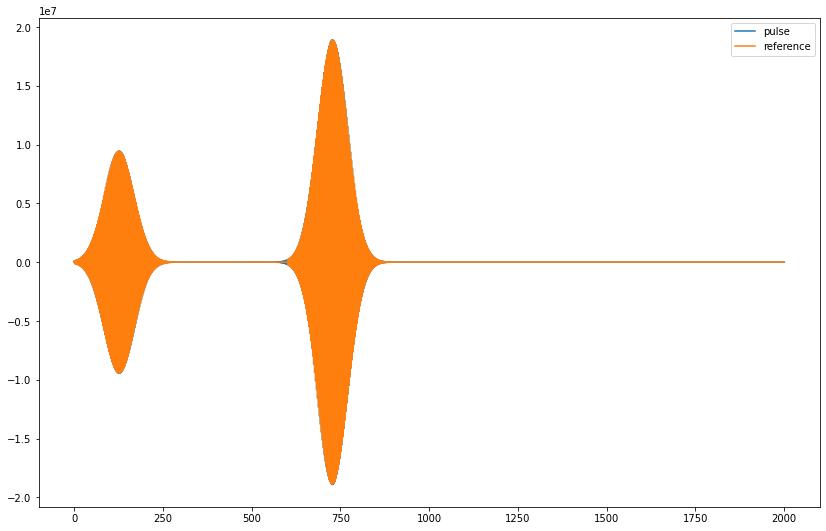

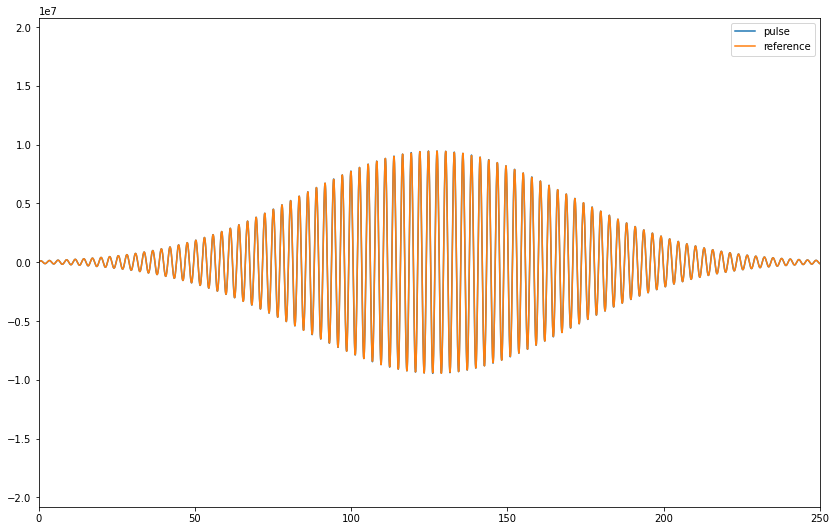

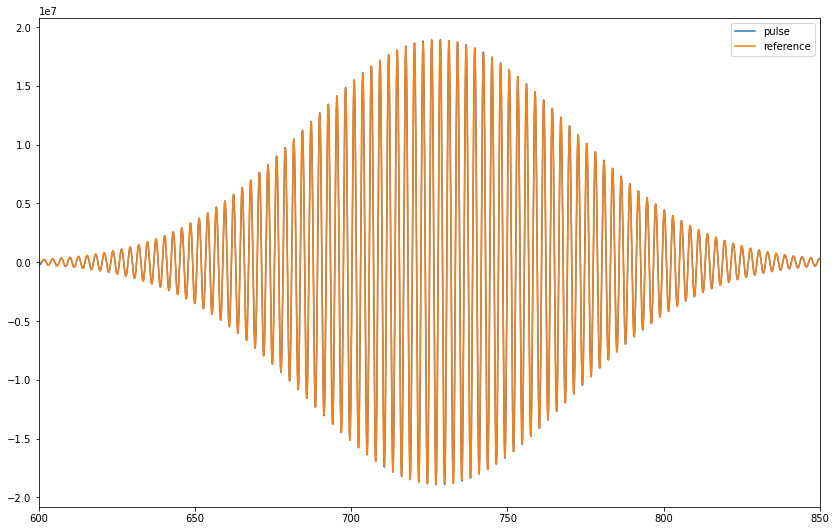

In [97]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,250)
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(600,850)
plt.show()

In [59]:
Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm,envelope_only=True,verbose=False)

In [105]:
Omega = lambda t : G.doubleGaussianPulse(t,energy=energy,amplitude1=pars1['Omega0_abs'],fwhm1=fwhm,
                amplitude2=pars2['Omega0_abs'],fwhm2=fwhm,t_start2=tstart,envelope_only=True,verbose=False)

In [106]:
uprime0 = np.array([0.,0.,-1.])

In [107]:
delta = energy - de_cv # in eV
delta_fsm1 = delta/h_red # in fs^-1
delta_fsm1

0.0

In [108]:
uprime = TLS.solveBlochEq(uprime0,time,Omega,mu=x_dip,delta=delta_fsm1)

We plot the carriers (rescaled by a factor 2 to be compared with the results of the yambo 
computation that has a spin degeneracy)

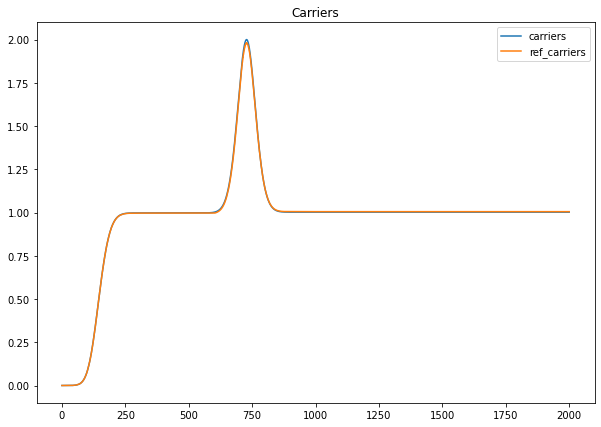

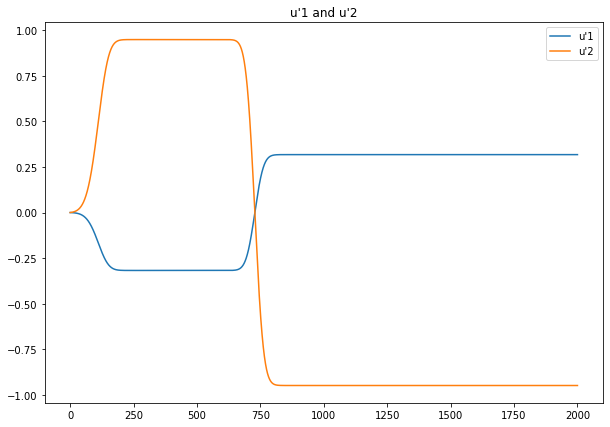

In [109]:
plt.figure(figsize=(10,7))
plt.title('Carriers')
plt.plot(time,(1+uprime[2]),label='carriers')
plt.plot(ref_time,ref_carriers,label='ref_carriers')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(time,uprime[0],label="u'1")
plt.plot(time,uprime[1],label="u'2")
plt.title("u'1 and u'2")
plt.legend()

We compare the other components of the Bloch vector in the original frame

In [110]:
u = TLS.convertToRotatingFrame(omega,time,uprime,invert=True)

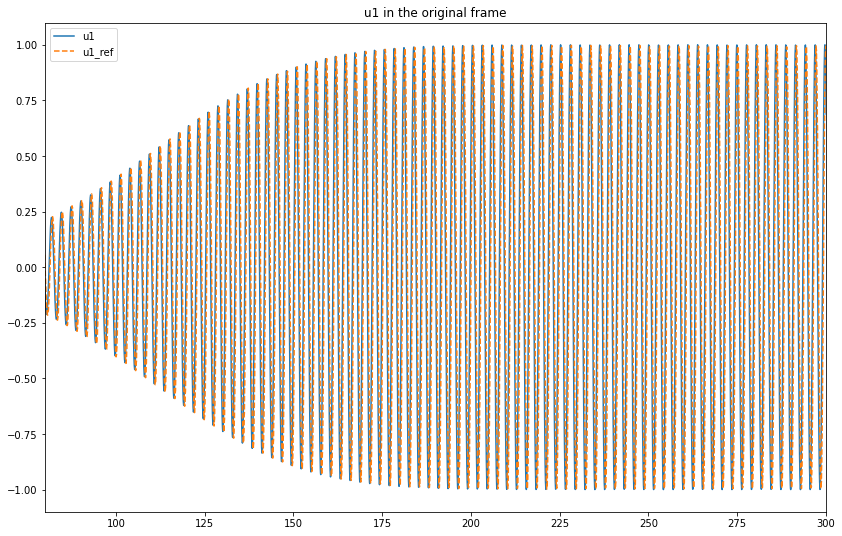

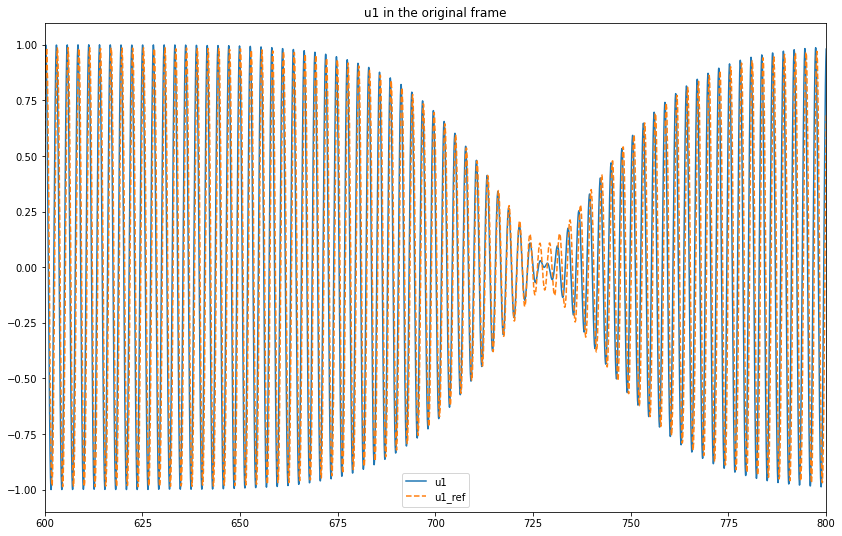

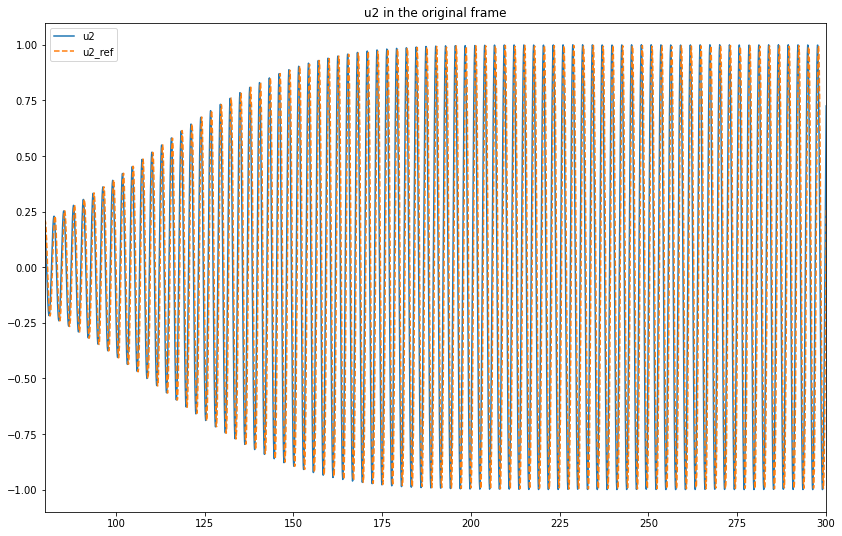

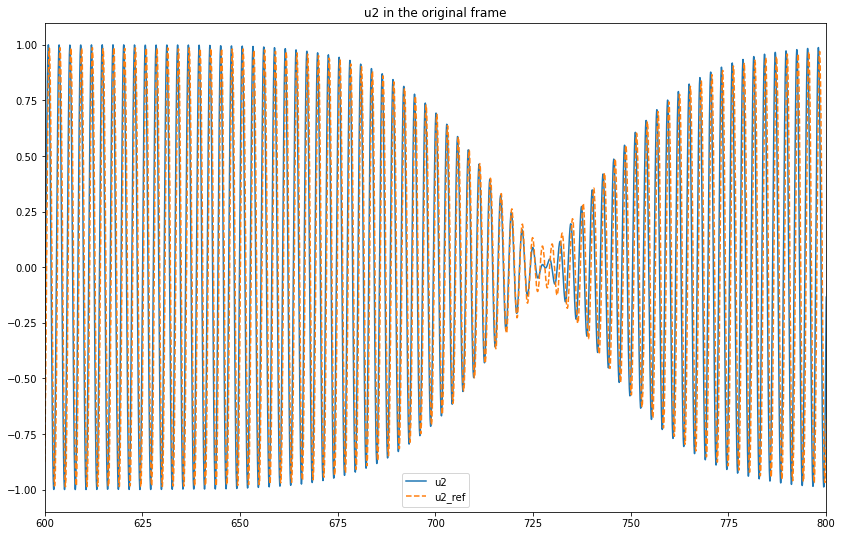

In [115]:
plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1')
plt.plot(time,Bloch[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1 in the original frame')
plt.xlim(80,300)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1')
plt.plot(time,Bloch[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1 in the original frame')
plt.xlim(600,800)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2')
plt.plot(time,Bloch[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2 in the original frame')
plt.xlim(80,300)
plt.legend()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2')
plt.plot(time,Bloch[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2 in the original frame')
plt.xlim(600,800)
plt.legend()

In [ ]:
##########################################################################################################

### Global dynamics in the single pulse configuration

In [35]:
T = 1000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [36]:
f = field_int_pi2

In [37]:
coupl_freqs = []
for k in range(len(dipoles)):
    coupl_freqs.append(R.eval_pulse_parameters(dipoles[k],f,width,verbose=False)[0])
coupl_freqs = np.array(coupl_freqs)

In [38]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: single_pulse(t,coupl_freqs[k],width)
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [39]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.2330971441577445


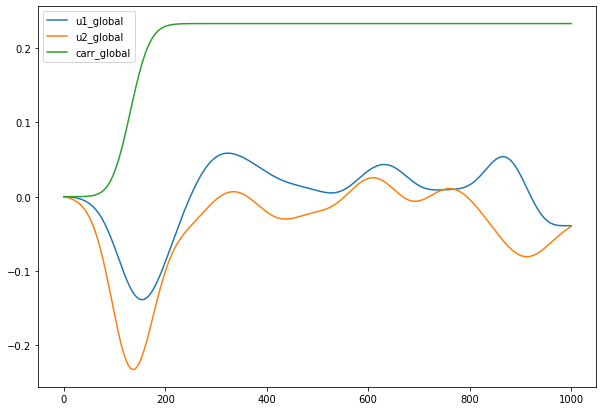

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [41]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [42]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

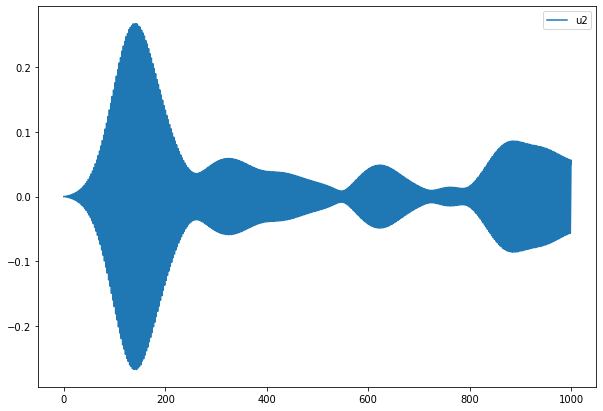

In [43]:
plt.figure(figsize=(10, 7))
#plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

### Global dynamics in the double pulse configuration. Echo mechanism

In [44]:
T = 4000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)
T1 = 1000 # delay between the pulses

In [45]:
coupl_freqs1 = []
coupl_freqs2 = []
for k in range(len(dipoles)):
    coupl_freqs1.append(R.eval_pulse_parameters(dipoles[k],field_int_pi2,width,verbose=False)[0])
    coupl_freqs2.append(R.eval_pulse_parameters(dipoles[k],field_int_pi,width,verbose=False)[0])
coupl_freqs1 = np.array(coupl_freqs1)
coupl_freqs2 = np.array(coupl_freqs2)

In [46]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: double_pulse(t,coupl_freqs1[k],width,T1,
                                 coupl_freqs2[k])
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [47]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.3883412820626765


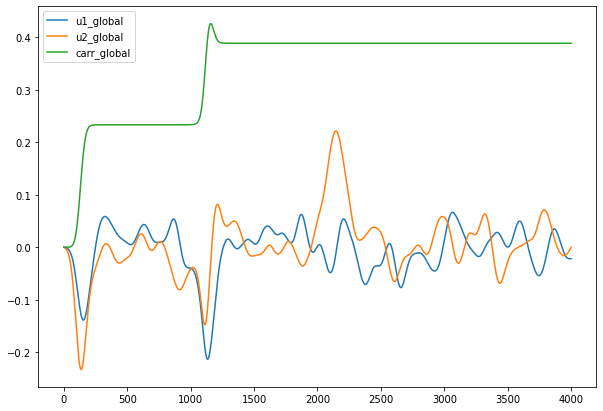

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [53]:
omega = pump_energy/h_red

In [54]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

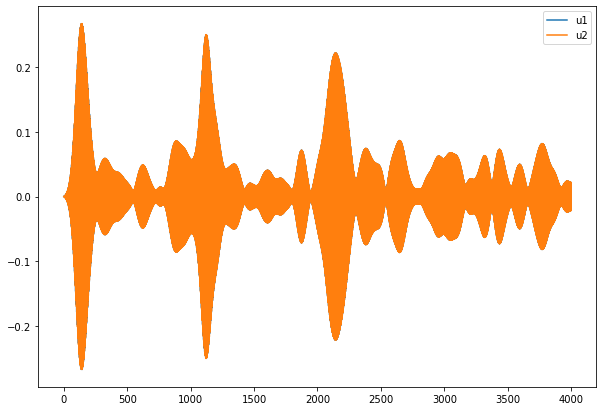

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

## TLS Analysis of GaAs (with optimal selection of the leading transition for each $k$-point)

.....TO BE UPDATED.....

We repeat the previous analysis with the improvement of selecting the leading transition for each $k$-point

In [25]:
def Bloch_Eq(u, t, delta, Omega_r):
    dudt = [delta*u[1], -delta*u[0]+Omega_r(t)*u[2],-Omega_r(t)*u[1]]
    return dudt

We study the FID and the echo mechanism using the transition dipoles and transition energies of the GaAs. 

We consider only the transition from the highest occupied bands to the lowest conduction
state, so that for each $k$-point the system behaves like a true TLS

In [26]:
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
width = 42.46609 # the field width in fs
pump_energy = 1.5 # eV
h = U.Planck_ev_ps*1e3 # Planck constant in ev*fs
h_red = U.Planck_ev_ps*1e3/(2*np.pi) # Reduced Planck constant in ev*fs

In [4]:
ndb_path = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm/eta_1e-05-field_eng_1.5-field_int_23758-sim_time_1000'
ndb = os.path.join(ndb_path,'ndb.dipoles')
save = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm/SAVE'
nkpoints = 1182

We build a dictionary that for each $k$-point contains the all the possible transition from ''valence'' to conduction states

In [27]:
dipoles_v1c = []
dipoles_v2c = []
dipoles_v3c = []

energies_v1c = []
energies_v2c = []
energies_v3c = []
for k in range(nkpoints):
    dipoles_v1c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[2,3]))
    energies_v1c.append(R.eval_trans_energy(save,kpoint=k,transition=[3,4],set_scissor=scissor))
    dipoles_v2c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[1,3]))
    energies_v2c.append(R.eval_trans_energy(save,kpoint=k,transition=[2,4],set_scissor=scissor))
    dipoles_v3c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[0,3]))
    energies_v3c.append(R.eval_trans_energy(save,kpoint=k,transition=[1,4],set_scissor=scissor))

transitions = {
    'v1c' : {'dipoles' : dipoles_v1c, 'energies' : energies_v1c},
    'v2c' : {'dipoles' : dipoles_v2c, 'energies' : energies_v2c},
    'v3c' : {'dipoles' : dipoles_v3c, 'energies' : energies_v3c}
}

We select the transition closest to the pump for each k point

In [28]:
select_transitions = []
trans_label = ['v1c','v2c','v3c']
for k in range(nkpoints):
    delta_trans = []
    for t in trans_label:
        delta_trans.append(pump_energy-transitions[t]['energies'][k])
    delta_trans = np.array(delta_trans)
    abs_trans = abs(delta_trans)
    select_transitions.append(trans_label[abs_trans.argmin()])

We choose the field intensity that for the $k$-point resonant with the pump energy gives the $\pi/2$ configuration

In [29]:
field_int_pi2 = 23758
field_int_pi = 95033
field_int_hi = 2e5

In [30]:
def eval_coupling_frequencies(field_int):
    coupling_frequencies = []
    Z0 = U.vacuum_impedence
    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units

    for k in range(nkpoints):
        dip = transitions[select_transitions[k]]['dipoles'][k]
        dip_mod = np.sqrt(dip[0]**2 + dip[1]**2)
        coupling_frequency = dip_mod*field_amp/h_red # om fs^-1  
        coupling_frequencies.append(coupling_frequency)
    return np.array(coupling_frequencies)

In [31]:
deltas = []
for k in range(nkpoints):
    deltas.append(pump_energy-transitions[select_transitions[k]]['energies'][k])

In [32]:
def single_pulse(t,A,width):
    t0 = 3*width
    return A*np.exp(-(t-t0)**2/(2.*width**2))

def double_pulse(t,A1,width,T1,A2):
    t0 = 3*width
    pulse1 = A1*np.exp(-(t-t0)**2/(2.*width**2))
    pulse2 = A2*np.exp(-(t-(t0+T1))**2/(2.*width**2))
    return pulse1 + pulse2

### Global dynamics in the single pulse configuration

In [33]:
T = 1000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [34]:
f = field_int_pi2

In [35]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
coupl_freq = eval_coupling_frequencies(f)
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: single_pulse(t,coupl_freq[k],width)
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [36]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.30697756826734235


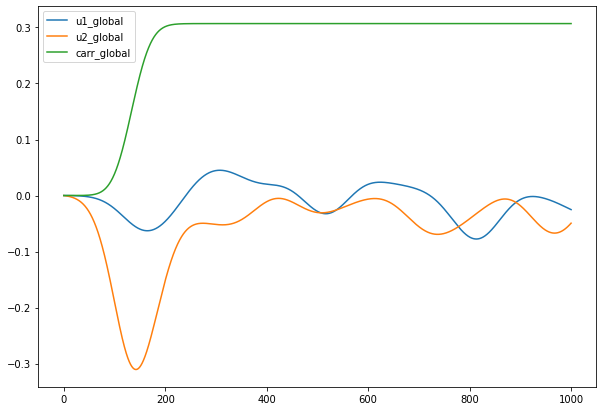

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [38]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [39]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

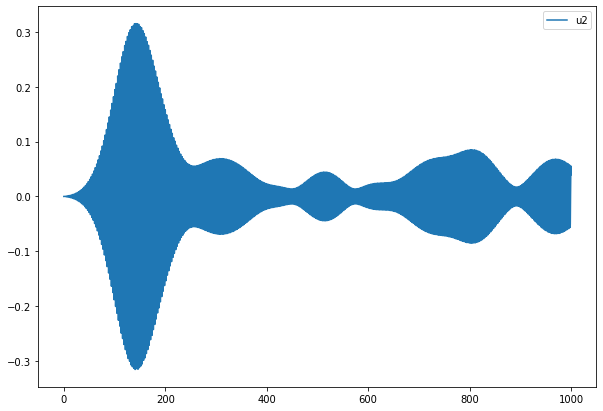

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
#plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

### Global dynamics in the double pulse configuration. Echo mechanism

In [41]:
T = 4000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)
T1 = 1000 # delay between the pulses

In [42]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
coupl_freq_pi2 = eval_coupling_frequencies(field_int_pi2)
coupl_freq_pi = eval_coupling_frequencies(field_int_pi)
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: double_pulse(t,coupl_freq_pi2[k],width,T1,
                                 coupl_freq_pi[k])
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [43]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.49034464053190707


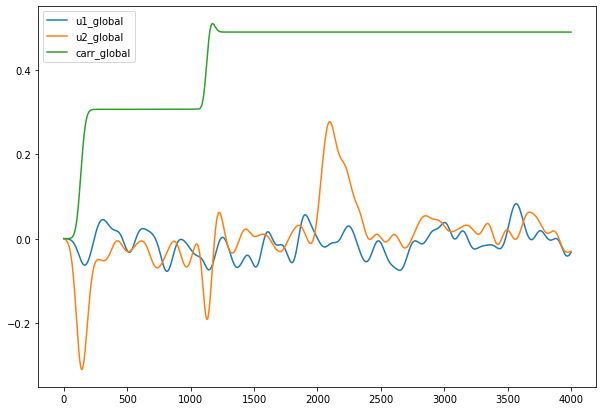

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [45]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [46]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

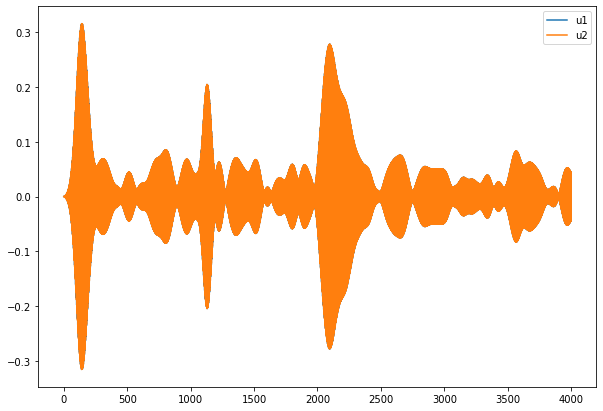

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')